In [1]:
#pip install --upgrade tensorflow

In [2]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import seaborn as sns
import cv2
import imghdr

In [4]:
# Importing the necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
from keras.regularizers import l1
from keras.regularizers import l2
import tensorflow as tf
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.config.list_physical_devices('GPU')


[]

In [7]:
data_dir = 'Data' 

In [8]:
os.listdir(data_dir)

['Big Ben',
 'Colosseum',
 'Egypt Pyramids',
 'Eiffel Tower',
 'London Bridge',
 'Petra',
 'Statue of Liberty',
 'Sudan Pyramids',
 'Sydney Opera House',
 'Taj Mahal']

In [9]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [10]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [11]:
data = tf.keras.utils.image_dataset_from_directory('Data')

Found 1557 files belonging to 10 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

In [14]:
len(batch)

2

In [15]:
# Image represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [16]:
batch[1]

array([9, 0, 6, 0, 4, 8, 6, 5, 1, 5, 3, 5, 3, 8, 1, 9, 7, 3, 8, 1, 8, 5,
       3, 3, 5, 1, 5, 2, 8, 4, 8, 8])

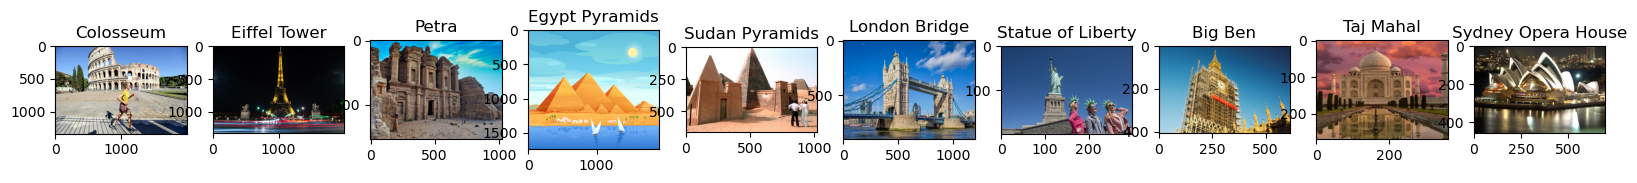

In [17]:
fig, ax = plt.subplots(ncols=10, figsize=(20,20))
for idx, folder in enumerate(['Colosseum', 'Eiffel Tower', 'Petra', 'Egypt Pyramids', 'Sudan Pyramids','London Bridge', 'Statue of Liberty','Big Ben','Taj Mahal','Sydney Opera House']):
    folder_path = os.path.join(data_dir, folder)
    image_files = os.listdir(folder_path)
    image_path = os.path.join(folder_path, image_files[0])  
    img = plt.imread(image_path)
    ax[idx].imshow(img)
    ax[idx].set_title(folder)


In [18]:
# Defining data augmentation transformations
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.2)
])

In [19]:
data = data.map(lambda x,y: (x/255, y))

In [20]:
data.as_numpy_iterator().next()

(array([[[[0.6331457 , 0.4919692 , 0.4056947 ],
          [0.66258043, 0.5205557 , 0.42653185],
          [0.6242283 , 0.4791303 , 0.3771695 ],
          ...,
          [0.31163642, 0.36800897, 0.41065603],
          [0.314501  , 0.37087354, 0.40594172],
          [0.36627412, 0.4102041 , 0.42883158]],
 
         [[0.61209404, 0.466996  , 0.39323682],
          [0.645818  , 0.50389093, 0.41986826],
          [0.7027976 , 0.56152725, 0.46998507],
          ...,
          [0.3179592 , 0.35836396, 0.3971833 ],
          [0.30505705, 0.3537856 , 0.38705575],
          [0.3372549 , 0.37161076, 0.39953086]],
 
         [[0.61319315, 0.46297872, 0.3949487 ],
          [0.61906594, 0.4739679 , 0.3994581 ],
          [0.61688113, 0.4717831 , 0.39727327],
          ...,
          [0.33333334, 0.37766543, 0.4288603 ],
          [0.33365312, 0.3779852 , 0.42918006],
          [0.3362745 , 0.37412685, 0.4170956 ]],
 
         ...,
 
         [[0.41413718, 0.30456877, 0.27965495],
          [0.40541

In [21]:
img_height = 160
img_width = 160
batch_size = 32

In [22]:
# Spliting the dataset into training and validation
train_size = tf.keras.preprocessing.image_dataset_from_directory(
data_dir,
validation_split=0.2,
subset="training",
seed=123,
image_size=(160, 160),
batch_size=160)
val_size = tf.keras.preprocessing.image_dataset_from_directory(
data_dir,
validation_split=0.2,
subset="validation",
seed=123,
image_size=(160, 160),
batch_size=32)

Found 1557 files belonging to 10 classes.
Using 1246 files for training.
Found 1557 files belonging to 10 classes.
Using 311 files for validation.


In [23]:
class_names = train_size.class_names
print(class_names)

['Big Ben', 'Colosseum', 'Egypt Pyramids', 'Eiffel Tower', 'London Bridge', 'Petra', 'Statue of Liberty', 'Sudan Pyramids', 'Sydney Opera House', 'Taj Mahal']


In [24]:
# Apply data augmentation to the training dataset
train_size = train_size.map(lambda x, y: (data_augmentation(x, training=True), y))

In [25]:
# Assigning Test dataset
test_dataset = val_size.take(5)
val_size = val_size.skip(5)

### Basic CNN model

In [26]:
model = Sequential()

model.add(Conv2D(32, (3, 3), strides=1, activation='relu', input_shape=(160, 160, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, (3, 3), strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax')) 

In [27]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(train_size, epochs=100, validation_data=val_size, callbacks=[tensorboard_callback])

Epoch 1/100
8/8 [==============================] - 30s 3s/step - loss: 14.1819 - accuracy: 0.1148 - val_loss: 2.2354 - val_accuracy: 0.2318
Epoch 2/100
8/8 [==============================] - 33s 3s/step - loss: 2.1506 - accuracy: 0.2135 - val_loss: 2.1655 - val_accuracy: 0.2252
Epoch 3/100
8/8 [==============================] - 32s 3s/step - loss: 2.0405 - accuracy: 0.2504 - val_loss: 1.9664 - val_accuracy: 0.2517
Epoch 4/100
8/8 [==============================] - 30s 3s/step - loss: 1.8531 - accuracy: 0.3170 - val_loss: 1.7603 - val_accuracy: 0.3775
Epoch 5/100
8/8 [==============================] - 30s 3s/step - loss: 1.7644 - accuracy: 0.3531 - val_loss: 2.2157 - val_accuracy: 0.2384
Epoch 6/100
8/8 [==============================] - 31s 3s/step - loss: 1.8389 - accuracy: 0.3226 - val_loss: 1.8843 - val_accuracy: 0.2185
Epoch 7/100
8/8 [==============================] - 36s 3s/step - loss: 1.7057 - accuracy: 0.3788 - val_loss: 1.7071 - val_accuracy: 0.3841
Epoch 8/100
8/8 [=========

8/8 [==============================] - 28s 3s/step - loss: 0.3369 - accuracy: 0.8900 - val_loss: 1.2792 - val_accuracy: 0.6490
Epoch 60/100
8/8 [==============================] - 33s 3s/step - loss: 0.2854 - accuracy: 0.9101 - val_loss: 1.0637 - val_accuracy: 0.7219
Epoch 61/100
8/8 [==============================] - 29s 2s/step - loss: 0.2290 - accuracy: 0.9173 - val_loss: 1.3268 - val_accuracy: 0.6755
Epoch 62/100
8/8 [==============================] - 34s 2s/step - loss: 0.2431 - accuracy: 0.9230 - val_loss: 1.4584 - val_accuracy: 0.6689
Epoch 63/100
8/8 [==============================] - 32s 3s/step - loss: 0.2210 - accuracy: 0.9254 - val_loss: 1.3114 - val_accuracy: 0.7417
Epoch 64/100
8/8 [==============================] - 26s 2s/step - loss: 0.2474 - accuracy: 0.9197 - val_loss: 1.1072 - val_accuracy: 0.7616
Epoch 65/100
8/8 [==============================] - 31s 2s/step - loss: 0.2514 - accuracy: 0.9141 - val_loss: 1.7023 - val_accuracy: 0.6291
Epoch 66/100
8/8 [===============

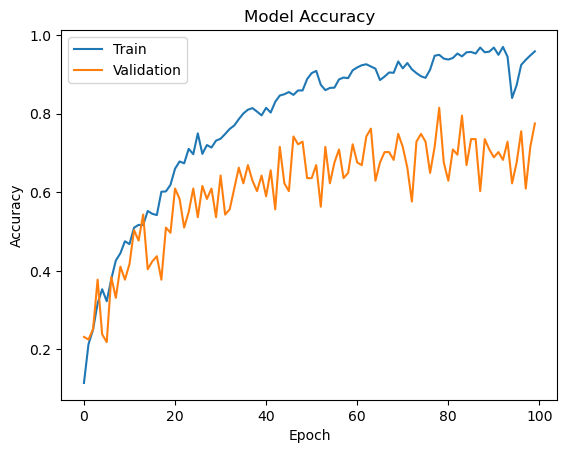

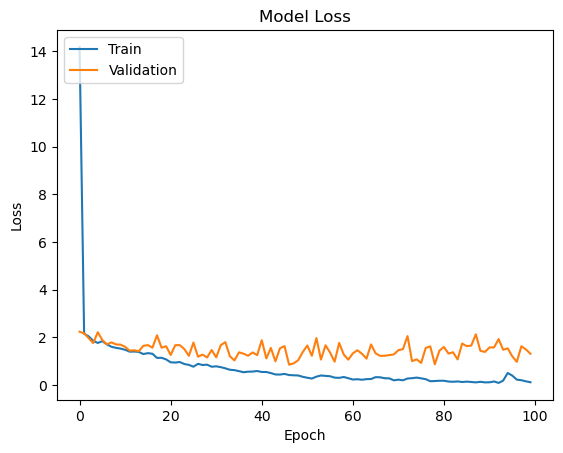

In [28]:
# plot accuracy and loss curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [29]:
# Getting the true labels and the predicted labels of your test data
y_true = []
y_pred = []
for images, labels in test_dataset:
  predictions = model.predict(images)
  y_true.extend(labels.numpy())
  y_pred.extend(np.argmax(predictions, axis=1))

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))


1/1 [==============================] - 0s 158ms/step
                    precision    recall  f1-score   support

           Big Ben       0.65      0.94      0.77        16
         Colosseum       0.56      0.91      0.69        11
    Egypt Pyramids       0.74      0.88      0.80        16
      Eiffel Tower       0.92      0.80      0.86        15
     London Bridge       0.85      0.58      0.69        19
             Petra       1.00      0.90      0.95        20
 Statue of Liberty       0.70      1.00      0.82         7
    Sudan Pyramids       1.00      0.75      0.86        24
Sydney Opera House       1.00      0.74      0.85        19
         Taj Mahal       0.71      0.77      0.74        13

          accuracy                           0.81       160
         macro avg       0.81      0.83      0.80       160
      weighted avg       0.85      0.81      0.81       160



<Figure size 2000x1000 with 0 Axes>

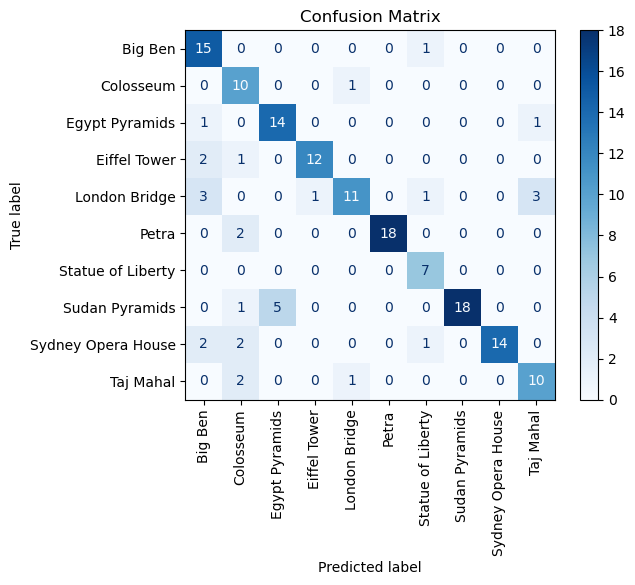

In [30]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display the confusion matrix with adjusted x-axis labels
plt.figure(dpi=200, figsize=(10, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')  # Adjust the angle of x-axis labels
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 113ms/step


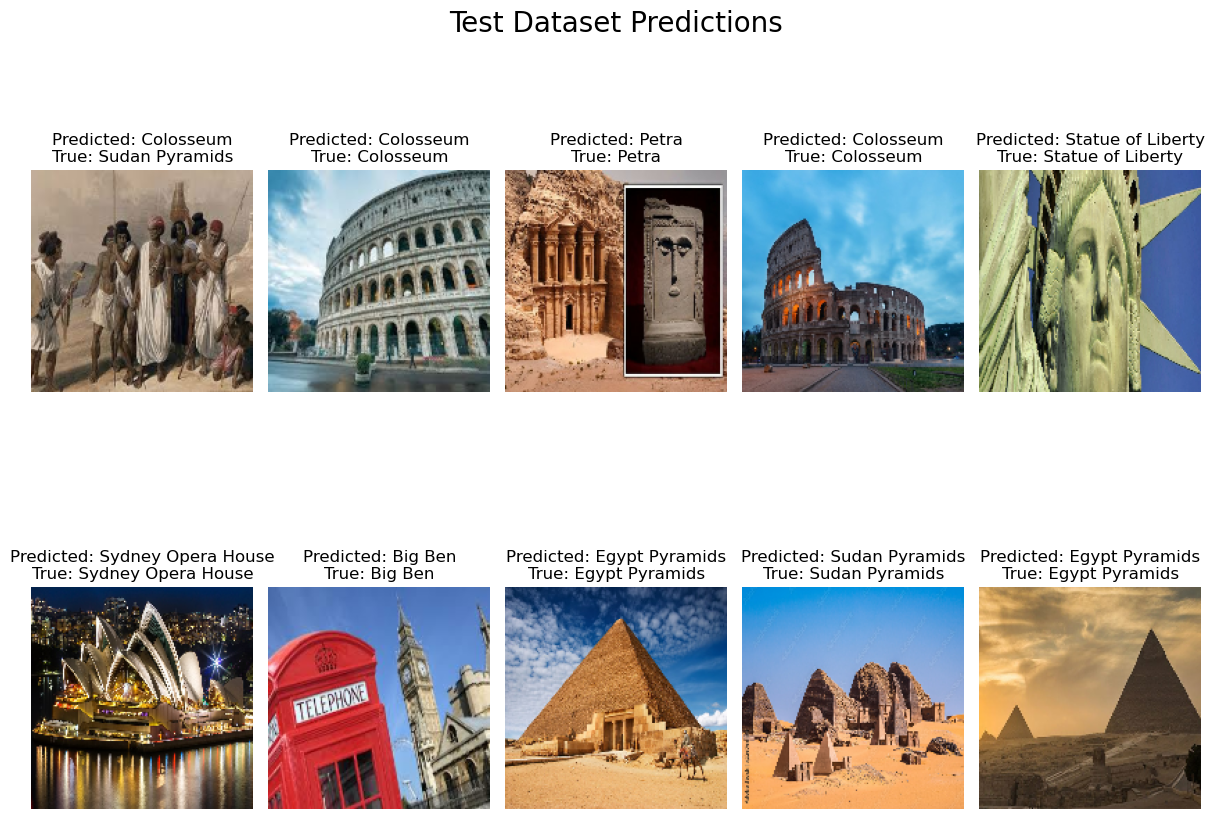

In [31]:
# Getting a batch of images from the test dataset
sample_images, sample_labels = next(iter(test_dataset))
sample_predictions = model.predict(sample_images)

# Mapping the predicted labels to class names
predicted_labels = [class_names[np.argmax(prediction)] for prediction in sample_predictions]

# Creating a figure with a grid of subplots for visualization
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))

# Looping through the subplots
for i in range(2):
    for j in range(5):
        idx = i * 5 + j  
# Preprocess and normalize the image
        image = sample_images[idx] / 255.0
        ax[i, j].set_title(f"Predicted: {predicted_labels[idx]}\nTrue: {class_names[sample_labels[idx]]}")
        ax[i, j].imshow(image)
        ax[i, j].axis("off")


plt.rcParams["figure.dpi"] = 300
plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()


### CNN model applying L2 Regularizer

In [32]:
model = Sequential()

model.add(Conv2D(32, (3, 3), strides=1, activation='relu', input_shape=(160, 160, 3), kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), strides=1, activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), strides=1, activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), strides=1, activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, (3, 3), strides=1, activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(train_size, epochs=100, validation_data=val_size, callbacks=[tensorboard_callback])


Epoch 1/100
8/8 [==============================] - 28s 3s/step - loss: 42.5175 - accuracy: 0.0851 - val_loss: 19.1554 - val_accuracy: 0.0795
Epoch 2/100
8/8 [==============================] - 25s 2s/step - loss: 17.9919 - accuracy: 0.1573 - val_loss: 16.6171 - val_accuracy: 0.1589
Epoch 3/100
8/8 [==============================] - 25s 2s/step - loss: 15.8260 - accuracy: 0.2255 - val_loss: 15.5953 - val_accuracy: 0.1523
Epoch 4/100
8/8 [==============================] - 24s 2s/step - loss: 14.5171 - accuracy: 0.2183 - val_loss: 13.8847 - val_accuracy: 0.2384
Epoch 5/100
8/8 [==============================] - 25s 2s/step - loss: 13.4919 - accuracy: 0.2849 - val_loss: 13.0729 - val_accuracy: 0.3311
Epoch 6/100
8/8 [==============================] - 24s 2s/step - loss: 12.7791 - accuracy: 0.3218 - val_loss: 12.5065 - val_accuracy: 0.2914
Epoch 7/100
8/8 [==============================] - 25s 2s/step - loss: 12.2316 - accuracy: 0.3323 - val_loss: 11.9826 - val_accuracy: 0.3907
Epoch 8/100
8

8/8 [==============================] - 25s 2s/step - loss: 4.9990 - accuracy: 0.7584 - val_loss: 5.5328 - val_accuracy: 0.6490
Epoch 60/100
8/8 [==============================] - 25s 2s/step - loss: 4.9502 - accuracy: 0.7536 - val_loss: 5.7260 - val_accuracy: 0.5563
Epoch 61/100
8/8 [==============================] - 24s 2s/step - loss: 4.9787 - accuracy: 0.7207 - val_loss: 5.1917 - val_accuracy: 0.6424
Epoch 62/100
8/8 [==============================] - 24s 2s/step - loss: 4.9776 - accuracy: 0.7135 - val_loss: 5.1862 - val_accuracy: 0.6490
Epoch 63/100
8/8 [==============================] - 25s 2s/step - loss: 4.8419 - accuracy: 0.7504 - val_loss: 5.4855 - val_accuracy: 0.5894
Epoch 64/100
8/8 [==============================] - 24s 2s/step - loss: 4.7183 - accuracy: 0.7745 - val_loss: 5.0821 - val_accuracy: 0.6821
Epoch 65/100
8/8 [==============================] - 25s 2s/step - loss: 4.6518 - accuracy: 0.7937 - val_loss: 5.0992 - val_accuracy: 0.6689
Epoch 66/100
8/8 [===============

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 158, 158, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 79, 79, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 77, 77, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 38, 38, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 36, 36, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 18, 18, 128)      

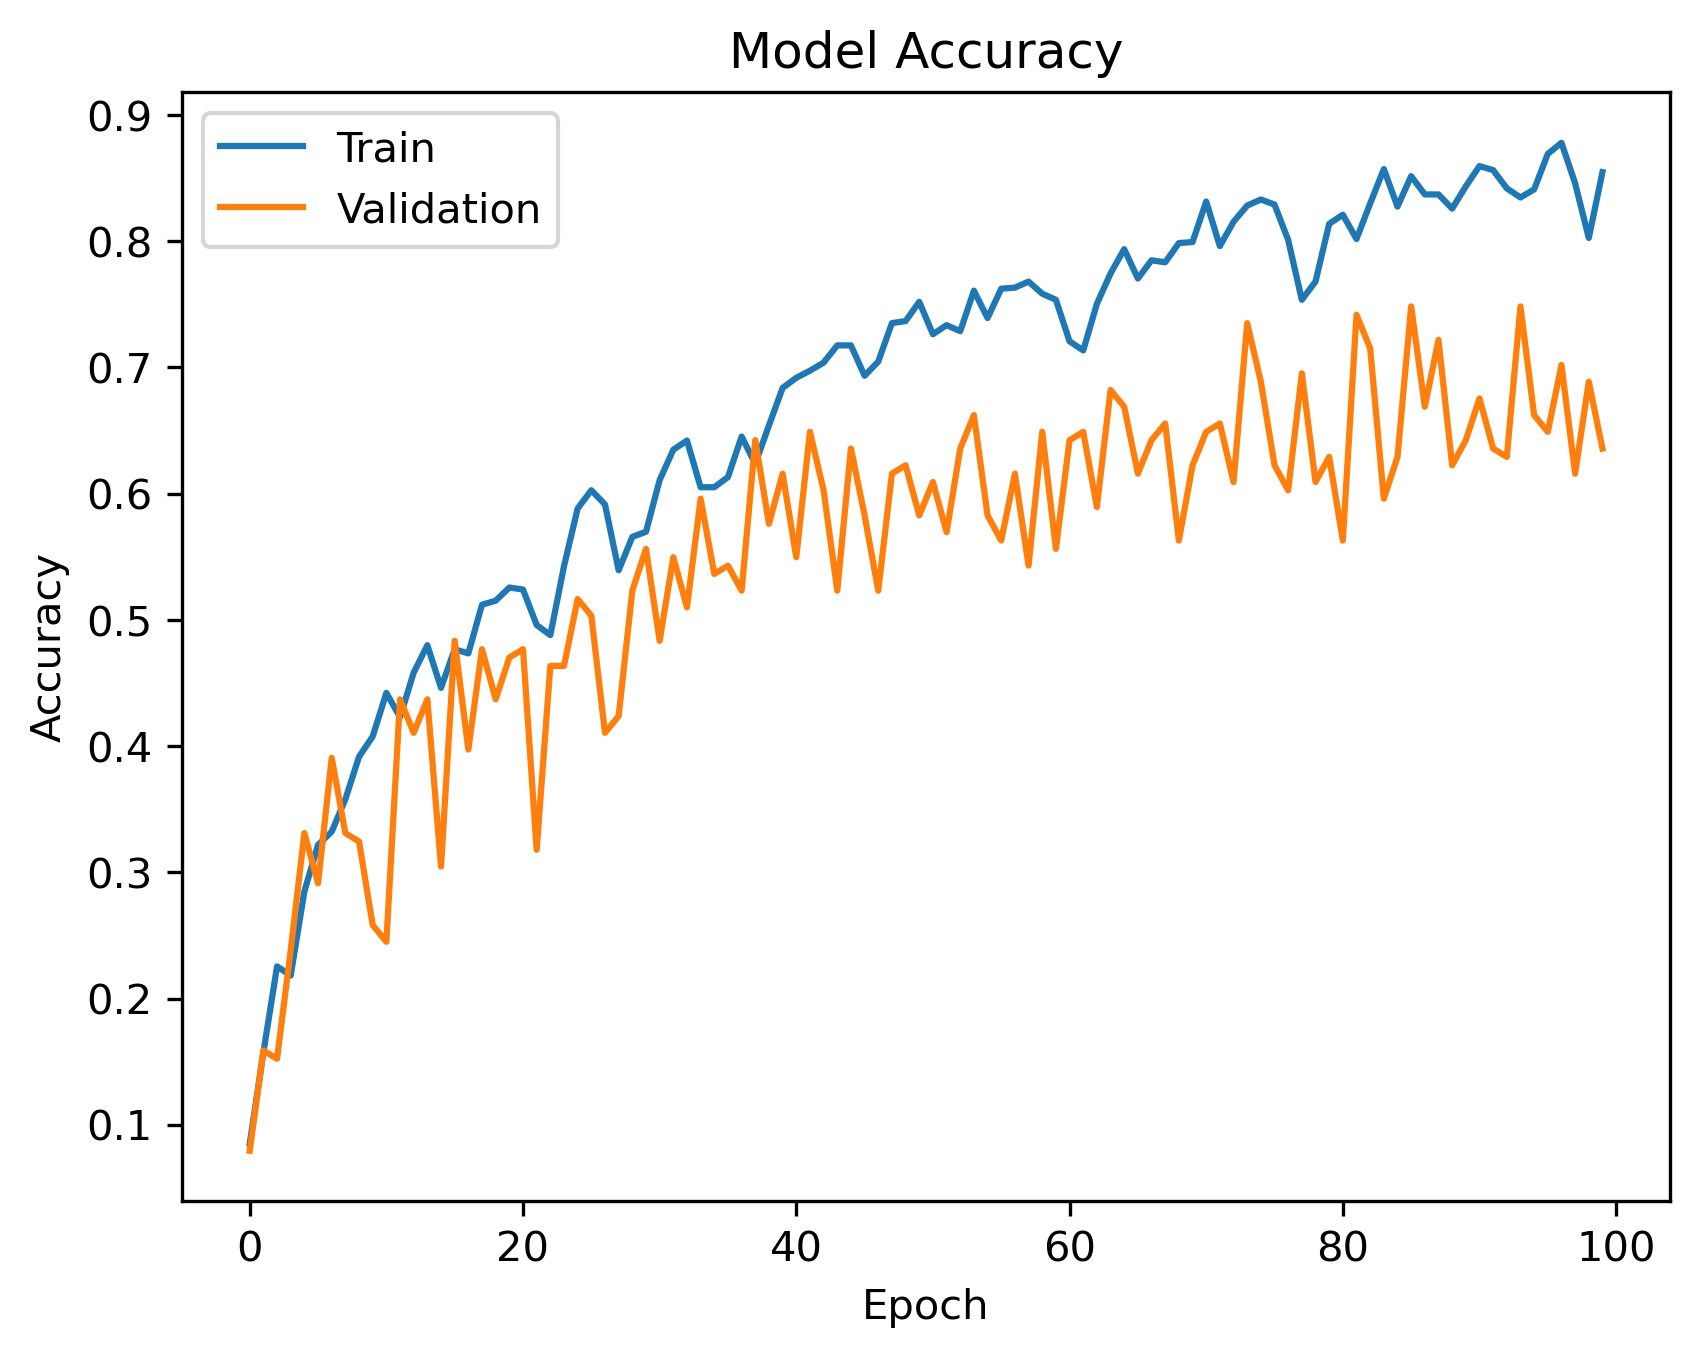

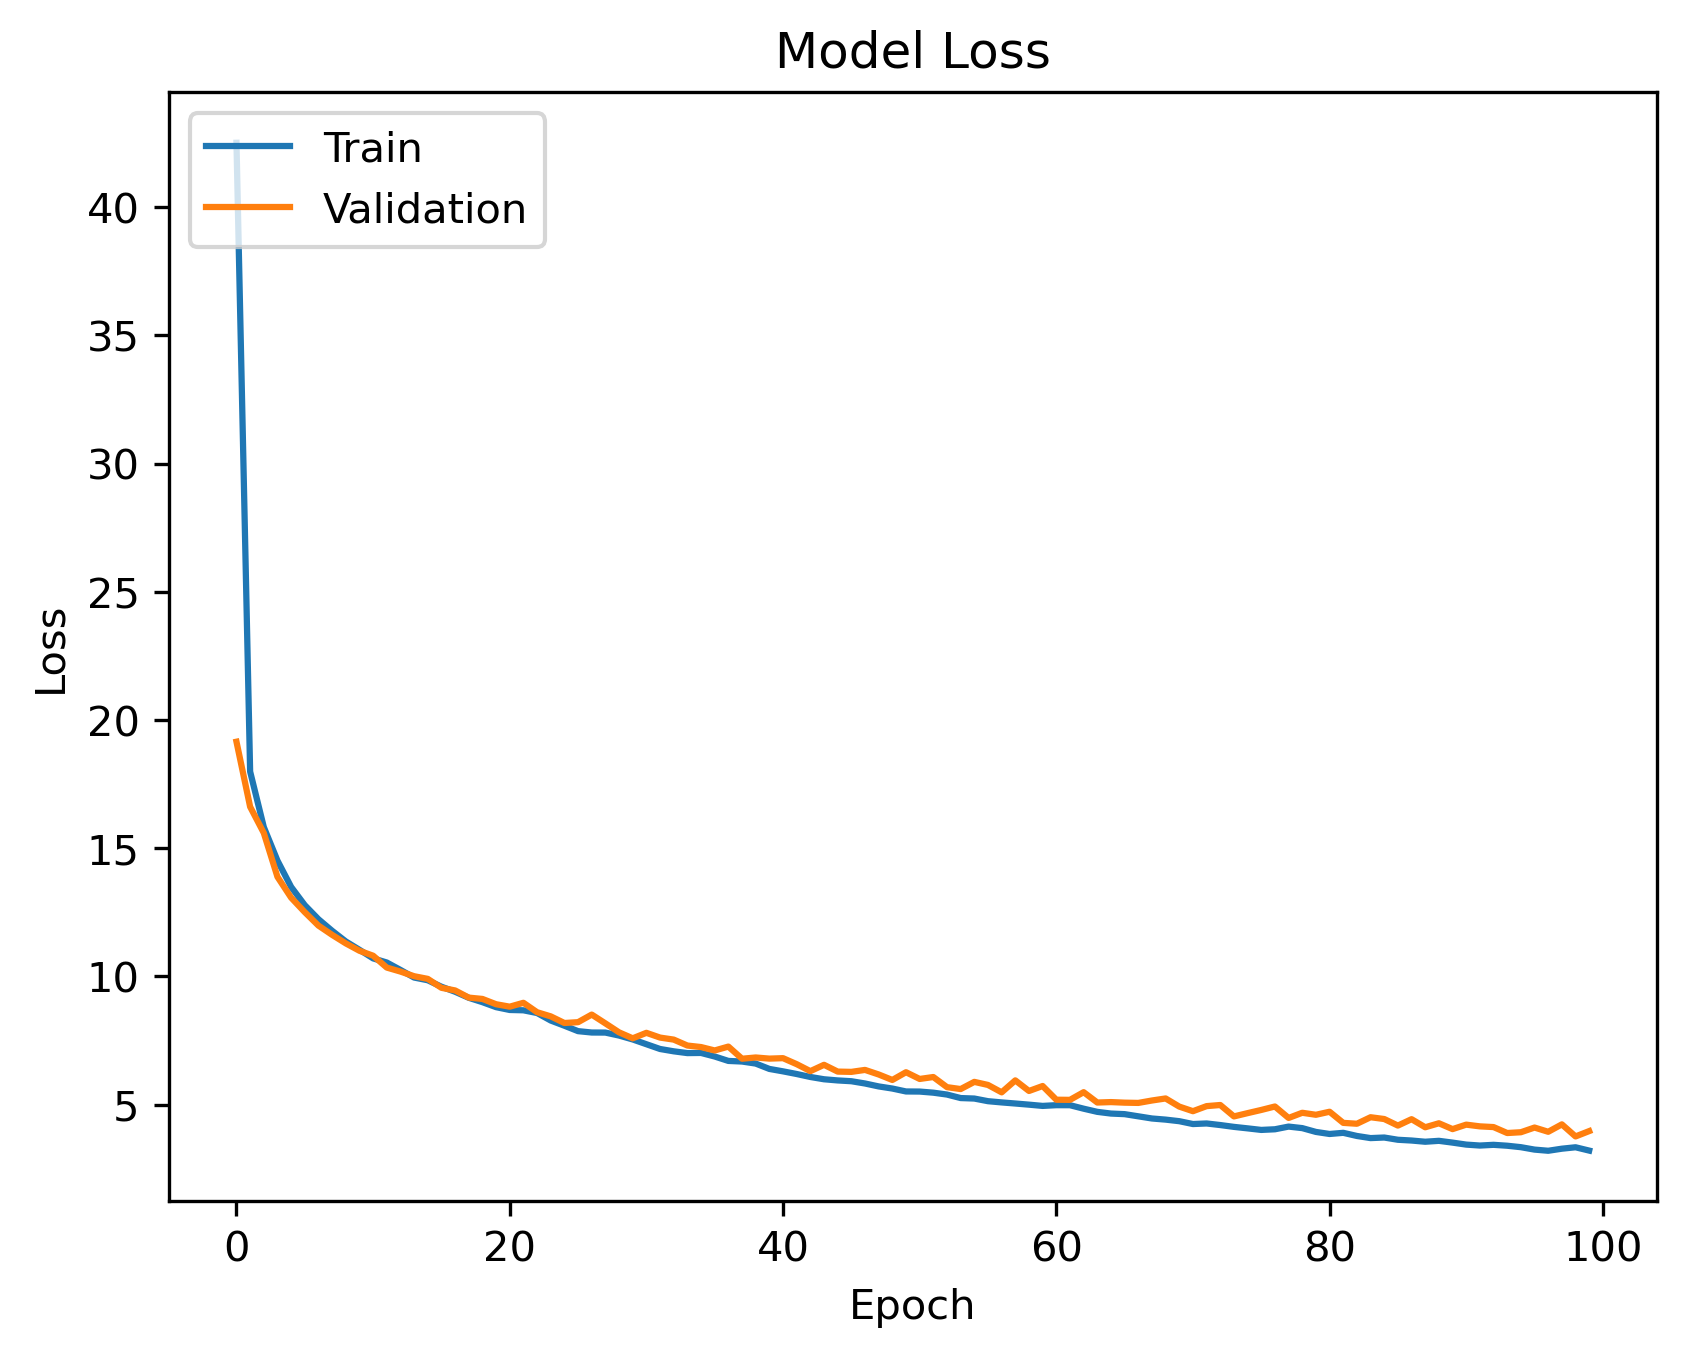

In [34]:
# plot accuracy and loss curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [35]:
# Getting the true labels and the predicted labels test data
y_true = []
y_pred = []
for images, labels in test_dataset:
  predictions = model.predict(images)
  y_true.extend(labels.numpy())
  y_pred.extend(np.argmax(predictions, axis=1))


print(classification_report(y_true, y_pred, target_names=class_names))


1/1 [==============================] - 0s 94ms/step
                    precision    recall  f1-score   support

           Big Ben       0.38      0.87      0.53        15
         Colosseum       0.58      0.79      0.67        14
    Egypt Pyramids       0.65      0.92      0.76        12
      Eiffel Tower       0.69      0.45      0.55        20
     London Bridge       0.58      0.67      0.62        21
             Petra       0.91      0.53      0.67        19
 Statue of Liberty       0.86      0.75      0.80         8
    Sudan Pyramids       0.88      0.70      0.78        20
Sydney Opera House       0.62      0.29      0.40        17
         Taj Mahal       0.73      0.57      0.64        14

          accuracy                           0.63       160
         macro avg       0.69      0.65      0.64       160
      weighted avg       0.69      0.63      0.63       160



<Figure size 2000x1000 with 0 Axes>

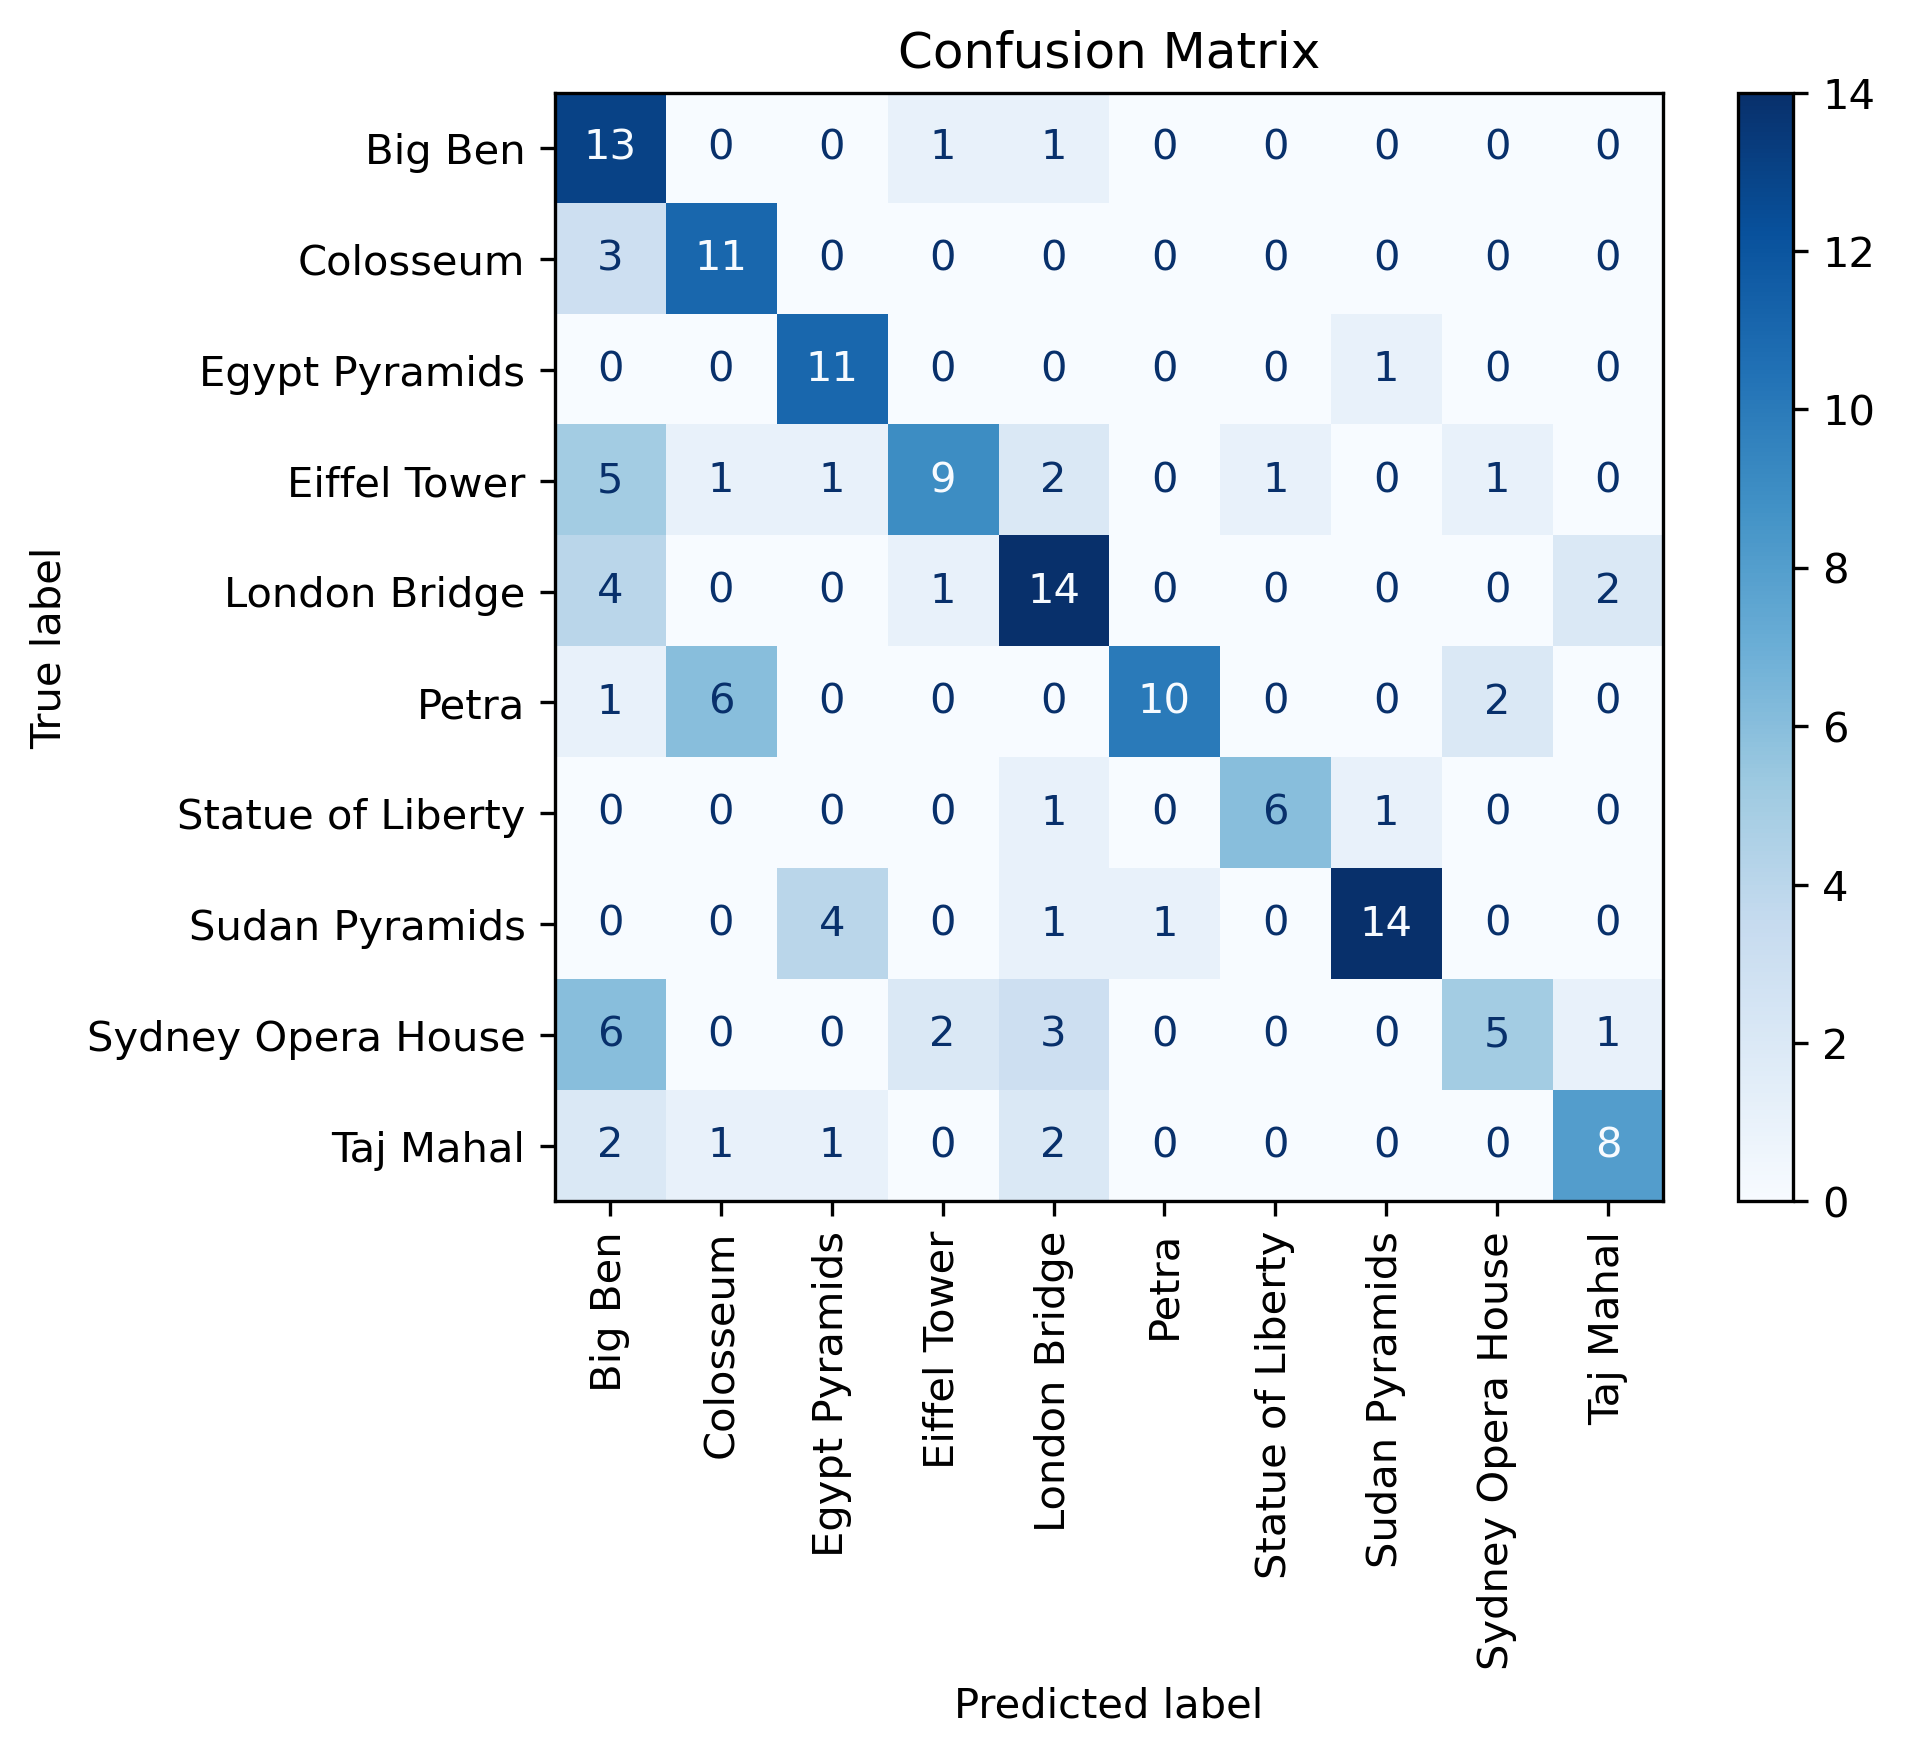

In [36]:
# Calculating the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Displaying the confusion matrix 
plt.figure(dpi=200, figsize=(10, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')  
plt.title('Confusion Matrix')
plt.show()

### CNN model applying Early stopping and Dropout layer

In [37]:
# Convert datasets to NumPy arrays
train_images = []
train_labels = []
for images, labels in train_size:
    train_images.append(images)
    train_labels.append(labels)
train_images = np.concatenate(train_images, axis=0)
train_labels = np.concatenate(train_labels, axis=0)

val_images = []
val_labels = []
for images, labels in val_size:
    val_images.append(images)
    val_labels.append(labels)
val_images = np.concatenate(val_images, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

# Definining the data augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [38]:
# Define the model with regularization and dropout
model = Sequential()
model.add(Conv2D(32, (3, 3), strides=1, activation='relu', input_shape=(160, 160, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, (3, 3), strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  
model.add(Dense(10, activation='softmax'))


In [39]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Implementing early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create a TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs', histogram_freq=1)

# Fit the model with data augmentation and callbacks
history = model.fit(
    data_augmentation.flow(train_images, train_labels),  
    epochs=100,
    validation_data=(val_images, val_labels),
    callbacks=[tensorboard_callback, early_stopping]
)


Epoch 1/100
39/39 [==============================] - 17s 417ms/step - loss: 3.8863 - accuracy: 0.1461 - val_loss: 2.1963 - val_accuracy: 0.1325
Epoch 2/100
39/39 [==============================] - 20s 510ms/step - loss: 2.1583 - accuracy: 0.1990 - val_loss: 1.9781 - val_accuracy: 0.2914
Epoch 3/100
39/39 [==============================] - 17s 445ms/step - loss: 2.0166 - accuracy: 0.2440 - val_loss: 1.9275 - val_accuracy: 0.2185
Epoch 4/100
39/39 [==============================] - 20s 508ms/step - loss: 1.9871 - accuracy: 0.2584 - val_loss: 1.8851 - val_accuracy: 0.2450
Epoch 5/100
39/39 [==============================] - 17s 436ms/step - loss: 1.9544 - accuracy: 0.2713 - val_loss: 2.0100 - val_accuracy: 0.2053
Epoch 6/100
39/39 [==============================] - 20s 501ms/step - loss: 1.9572 - accuracy: 0.2673 - val_loss: 1.9485 - val_accuracy: 0.2450
Epoch 7/100
39/39 [==============================] - 19s 483ms/step - loss: 1.9543 - accuracy: 0.2552 - val_loss: 1.7928 - val_accuracy:

39/39 [==============================] - 20s 523ms/step - loss: 0.8006 - accuracy: 0.7376 - val_loss: 1.4371 - val_accuracy: 0.6424
Epoch 58/100
39/39 [==============================] - 19s 465ms/step - loss: 0.8890 - accuracy: 0.7111 - val_loss: 1.1712 - val_accuracy: 0.6490
Epoch 59/100
39/39 [==============================] - 19s 483ms/step - loss: 0.8184 - accuracy: 0.7215 - val_loss: 1.0686 - val_accuracy: 0.6225
Epoch 60/100
39/39 [==============================] - 19s 475ms/step - loss: 0.8878 - accuracy: 0.6974 - val_loss: 0.9207 - val_accuracy: 0.6954
Epoch 61/100
39/39 [==============================] - 17s 428ms/step - loss: 0.7757 - accuracy: 0.7464 - val_loss: 1.3394 - val_accuracy: 0.6821
Epoch 62/100
39/39 [==============================] - 19s 487ms/step - loss: 0.8053 - accuracy: 0.7311 - val_loss: 1.0837 - val_accuracy: 0.6954
Epoch 63/100
39/39 [==============================] - 19s 484ms/step - loss: 0.7414 - accuracy: 0.7624 - val_loss: 1.4380 - val_accuracy: 0.602

In [40]:
# Getting the true labels and the predicted labels of test data
y_true = []
y_pred = []
for images, labels in test_dataset:
  predictions = model.predict(images)
  y_true.extend(labels.numpy())
  y_pred.extend(np.argmax(predictions, axis=1))

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))


1/1 [==============================] - 0s 111ms/step
                    precision    recall  f1-score   support

           Big Ben       0.52      0.65      0.58        17
         Colosseum       0.60      0.75      0.67         8
    Egypt Pyramids       0.69      0.75      0.72        12
      Eiffel Tower       0.60      0.71      0.65        17
     London Bridge       0.50      0.56      0.53        18
             Petra       0.93      0.68      0.79        19
 Statue of Liberty       1.00      0.56      0.71         9
    Sudan Pyramids       0.86      0.83      0.84        23
Sydney Opera House       0.50      0.59      0.54        17
         Taj Mahal       0.87      0.65      0.74        20

          accuracy                           0.68       160
         macro avg       0.71      0.67      0.68       160
      weighted avg       0.71      0.68      0.68       160



<Figure size 2000x1000 with 0 Axes>

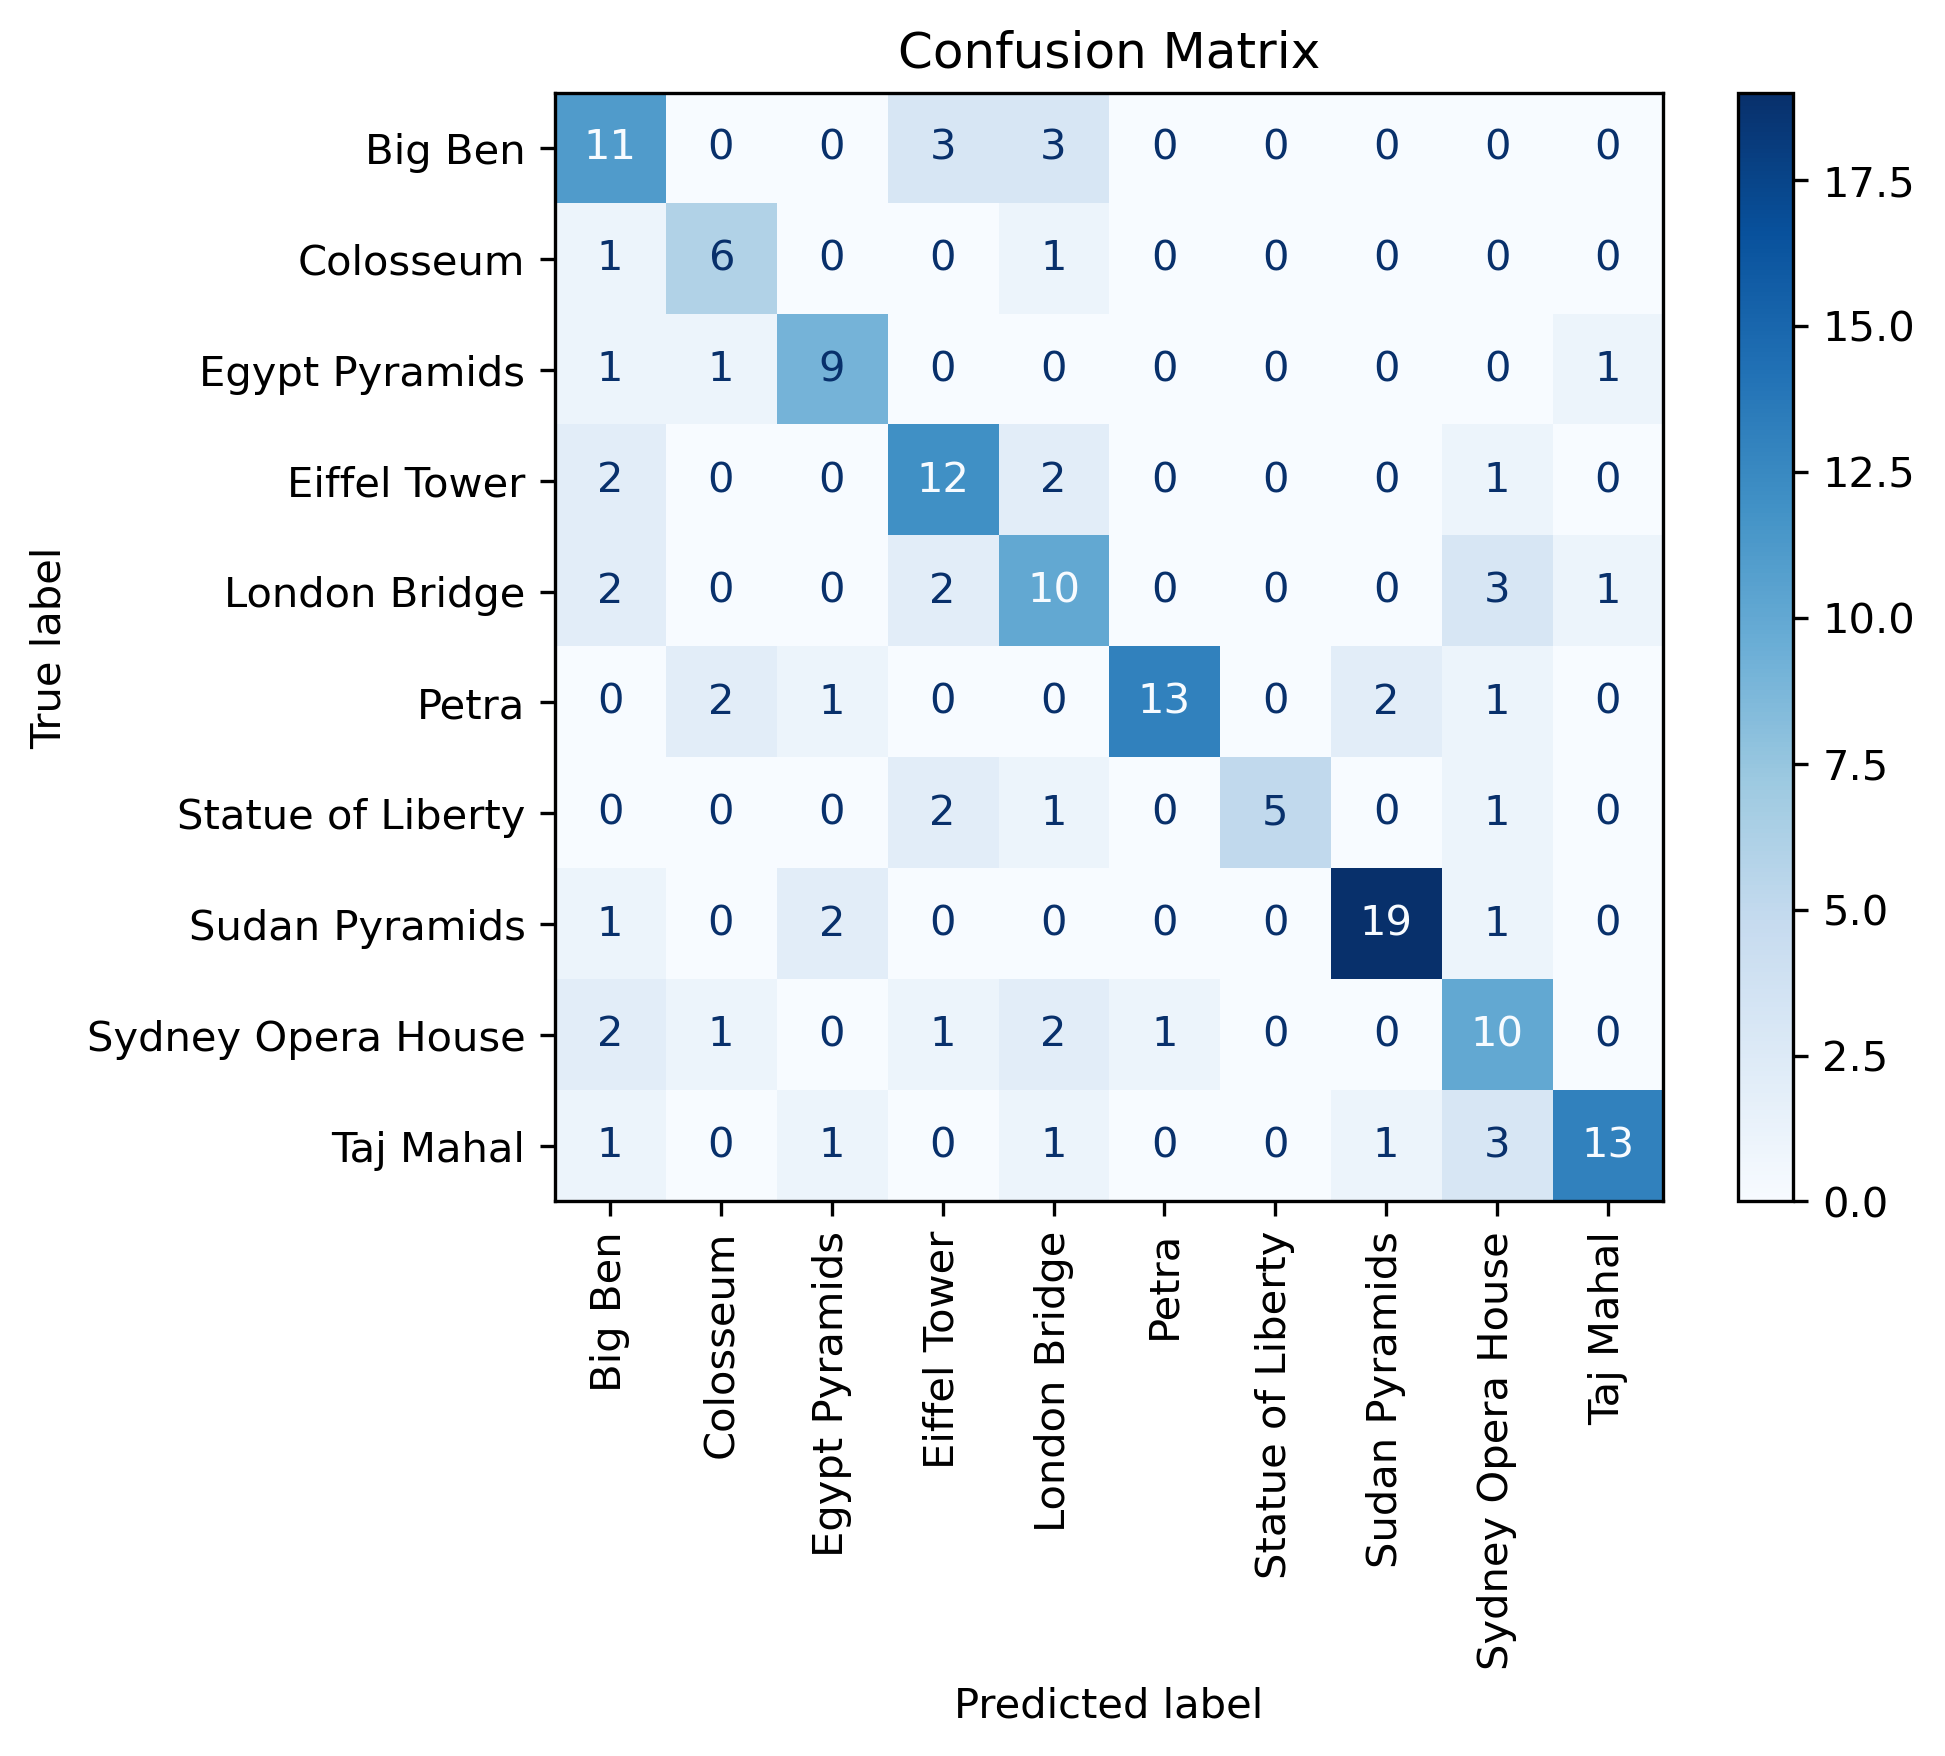

In [41]:
# Calculating the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Displaying the confusion matrix 
plt.figure(dpi=200, figsize=(10, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')  
plt.title('Confusion Matrix')
plt.show()

### CNN model adding L2 regularization, Batch Normalization, and Dropout

In [42]:
# Convert datasets to NumPy arrays
train_images = []
train_labels = []
for images, labels in train_size:
    train_images.append(images)
    train_labels.append(labels)
train_images = np.concatenate(train_images, axis=0)
train_labels = np.concatenate(train_labels, axis=0)

val_images = []
val_labels = []
for images, labels in val_size:
    val_images.append(images)
    val_labels.append(labels)
val_images = np.concatenate(val_images, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

# Definining the data augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [43]:
# Define the model with regularization, batch normalization, and dropout
model = Sequential()
model.add(Conv2D(32, (3, 3), strides=1, activation='relu', input_shape=(160, 160, 3), kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), strides=1, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), strides=1, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), strides=1, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, (3, 3), strides=1, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


In [44]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Create a TensorBoard callback
tensorboard_callback = TensorBoard(log_dir='logs', histogram_freq=1)

# Fit the model with data augmentation and callbacks
history = model.fit(
    data_augmentation.flow(train_images, train_labels),
    epochs=100,
    validation_data=(val_images, val_labels),
    callbacks=[tensorboard_callback]
)


Epoch 1/100
39/39 [==============================] - 27s 653ms/step - loss: 25.3440 - accuracy: 0.1709 - val_loss: 24.2703 - val_accuracy: 0.1457
Epoch 2/100
39/39 [==============================] - 25s 648ms/step - loss: 21.4584 - accuracy: 0.2255 - val_loss: 19.5027 - val_accuracy: 0.1722
Epoch 3/100
39/39 [==============================] - 25s 628ms/step - loss: 18.2956 - accuracy: 0.2536 - val_loss: 16.6304 - val_accuracy: 0.1921
Epoch 4/100
39/39 [==============================] - 25s 629ms/step - loss: 15.6246 - accuracy: 0.3026 - val_loss: 14.4818 - val_accuracy: 0.1722
Epoch 5/100
39/39 [==============================] - 25s 640ms/step - loss: 13.4403 - accuracy: 0.2905 - val_loss: 12.4868 - val_accuracy: 0.2119
Epoch 6/100
39/39 [==============================] - 25s 646ms/step - loss: 11.5035 - accuracy: 0.3411 - val_loss: 10.8308 - val_accuracy: 0.1854
Epoch 7/100
39/39 [==============================] - 24s 612ms/step - loss: 9.9304 - accuracy: 0.3620 - val_loss: 9.6459 - v

39/39 [==============================] - 25s 637ms/step - loss: 2.3451 - accuracy: 0.5409 - val_loss: 2.7824 - val_accuracy: 0.3841
Epoch 58/100
39/39 [==============================] - 24s 617ms/step - loss: 2.2360 - accuracy: 0.5746 - val_loss: 2.2671 - val_accuracy: 0.5166
Epoch 59/100
39/39 [==============================] - 24s 617ms/step - loss: 2.2896 - accuracy: 0.5602 - val_loss: 2.9435 - val_accuracy: 0.3179
Epoch 60/100
39/39 [==============================] - 24s 622ms/step - loss: 2.2226 - accuracy: 0.5867 - val_loss: 2.2483 - val_accuracy: 0.5298
Epoch 61/100
39/39 [==============================] - 24s 617ms/step - loss: 2.2805 - accuracy: 0.5522 - val_loss: 3.8078 - val_accuracy: 0.2384
Epoch 62/100
39/39 [==============================] - 24s 623ms/step - loss: 2.1737 - accuracy: 0.5778 - val_loss: 2.4159 - val_accuracy: 0.5033
Epoch 63/100
39/39 [==============================] - 24s 623ms/step - loss: 2.2634 - accuracy: 0.5674 - val_loss: 2.6570 - val_accuracy: 0.410

In [45]:
# Getting the true labels and the predicted labels of your test data
y_true = []
y_pred = []
for images, labels in test_dataset:
  predictions = model.predict(images)
  y_true.extend(labels.numpy())
  y_pred.extend(np.argmax(predictions, axis=1))

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))


1/1 [==============================] - 0s 130ms/step
                    precision    recall  f1-score   support

           Big Ben       0.13      0.46      0.20        13
         Colosseum       1.00      0.12      0.22         8
    Egypt Pyramids       0.28      0.92      0.43        13
      Eiffel Tower       0.25      0.06      0.09        18
     London Bridge       0.31      0.24      0.27        17
             Petra       0.92      0.50      0.65        24
 Statue of Liberty       0.50      0.62      0.56         8
    Sudan Pyramids       0.53      0.36      0.43        22
Sydney Opera House       0.67      0.21      0.32        19
         Taj Mahal       0.78      0.39      0.52        18

          accuracy                           0.38       160
         macro avg       0.54      0.39      0.37       160
      weighted avg       0.55      0.38      0.38       160



<Figure size 2000x1000 with 0 Axes>

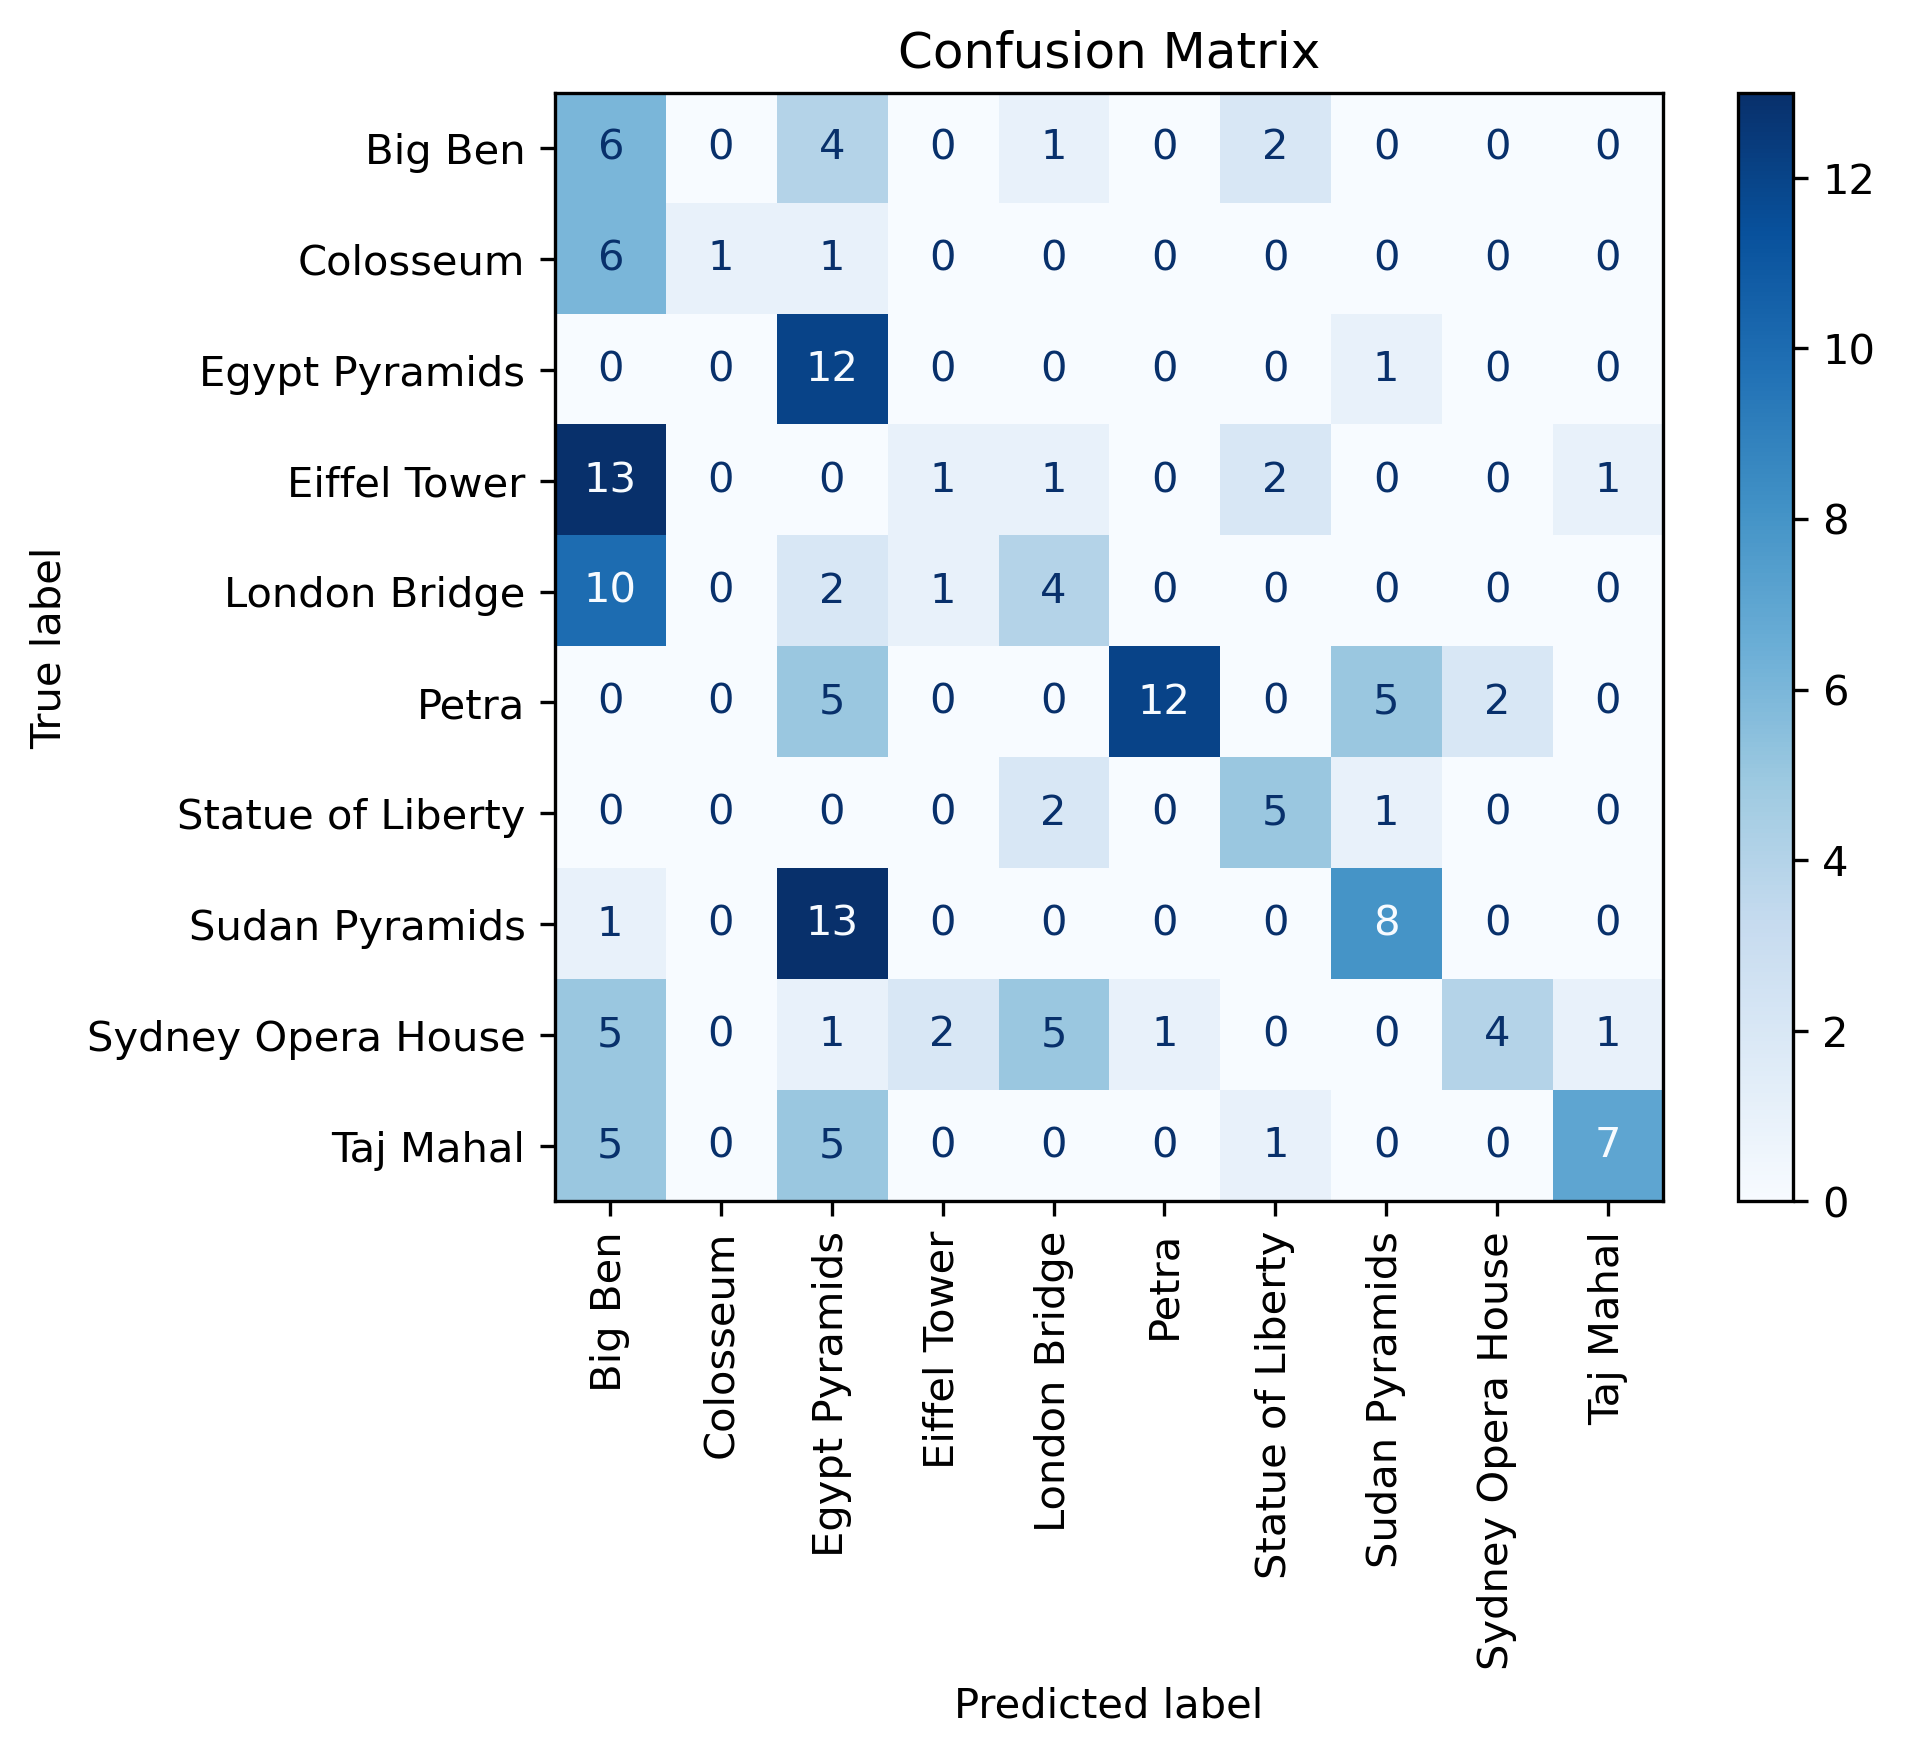

In [46]:
# Calculating the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Displaying the confusion matrix 
plt.figure(dpi=200, figsize=(10, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')  
plt.title('Confusion Matrix')
plt.show()

In [47]:

# Define the model with regularization, batch normalization, and dropout
model = Sequential()
model.add(Conv2D(32, (3, 3), strides=1, activation='relu', input_shape=(160, 160, 3), kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), strides=1, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), strides=1, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), strides=1, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, (3, 3), strides=1, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Use RMSprop optimizer with a fixed learning rate
optimizer = RMSprop(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Create a TensorBoard callback
tensorboard_callback = TensorBoard(log_dir='logs', histogram_freq=1)

# Fit the model with data augmentation and callbacks
history = model.fit(
    data_augmentation.flow(train_images, train_labels),
    epochs=100,
    validation_data=(val_images, val_labels),
    callbacks=[tensorboard_callback]
)


Epoch 1/100
39/39 [==============================] - 27s 655ms/step - loss: 25.7354 - accuracy: 0.1822 - val_loss: 26.3002 - val_accuracy: 0.1192
Epoch 2/100
39/39 [==============================] - 24s 594ms/step - loss: 20.8443 - accuracy: 0.2014 - val_loss: 17.8164 - val_accuracy: 0.1192
Epoch 3/100
39/39 [==============================] - 25s 623ms/step - loss: 16.5445 - accuracy: 0.2319 - val_loss: 14.4542 - val_accuracy: 0.1722
Epoch 4/100
39/39 [==============================] - 24s 605ms/step - loss: 12.9369 - accuracy: 0.2087 - val_loss: 11.4198 - val_accuracy: 0.1589
Epoch 5/100
39/39 [==============================] - 25s 626ms/step - loss: 9.9040 - accuracy: 0.2472 - val_loss: 8.5265 - val_accuracy: 0.1126
Epoch 6/100
39/39 [==============================] - 25s 626ms/step - loss: 7.6398 - accuracy: 0.2608 - val_loss: 6.7391 - val_accuracy: 0.1325
Epoch 7/100
39/39 [==============================] - 25s 630ms/step - loss: 6.2746 - accuracy: 0.2801 - val_loss: 8.0494 - val_a

39/39 [==============================] - 24s 620ms/step - loss: 1.9661 - accuracy: 0.4735 - val_loss: 2.0785 - val_accuracy: 0.3907
Epoch 58/100
39/39 [==============================] - 24s 620ms/step - loss: 1.8859 - accuracy: 0.4896 - val_loss: 2.3069 - val_accuracy: 0.3245
Epoch 59/100
39/39 [==============================] - 24s 616ms/step - loss: 1.8886 - accuracy: 0.4751 - val_loss: 2.2858 - val_accuracy: 0.3576
Epoch 60/100
39/39 [==============================] - 24s 618ms/step - loss: 1.8522 - accuracy: 0.4952 - val_loss: 2.3156 - val_accuracy: 0.2848
Epoch 61/100
39/39 [==============================] - 24s 619ms/step - loss: 1.8363 - accuracy: 0.4944 - val_loss: 1.9597 - val_accuracy: 0.4040
Epoch 62/100
39/39 [==============================] - 24s 618ms/step - loss: 1.8694 - accuracy: 0.4791 - val_loss: 2.3788 - val_accuracy: 0.3046
Epoch 63/100
39/39 [==============================] - 24s 619ms/step - loss: 1.9069 - accuracy: 0.4904 - val_loss: 2.0554 - val_accuracy: 0.377

1/1 [==============================] - 0s 180ms/step


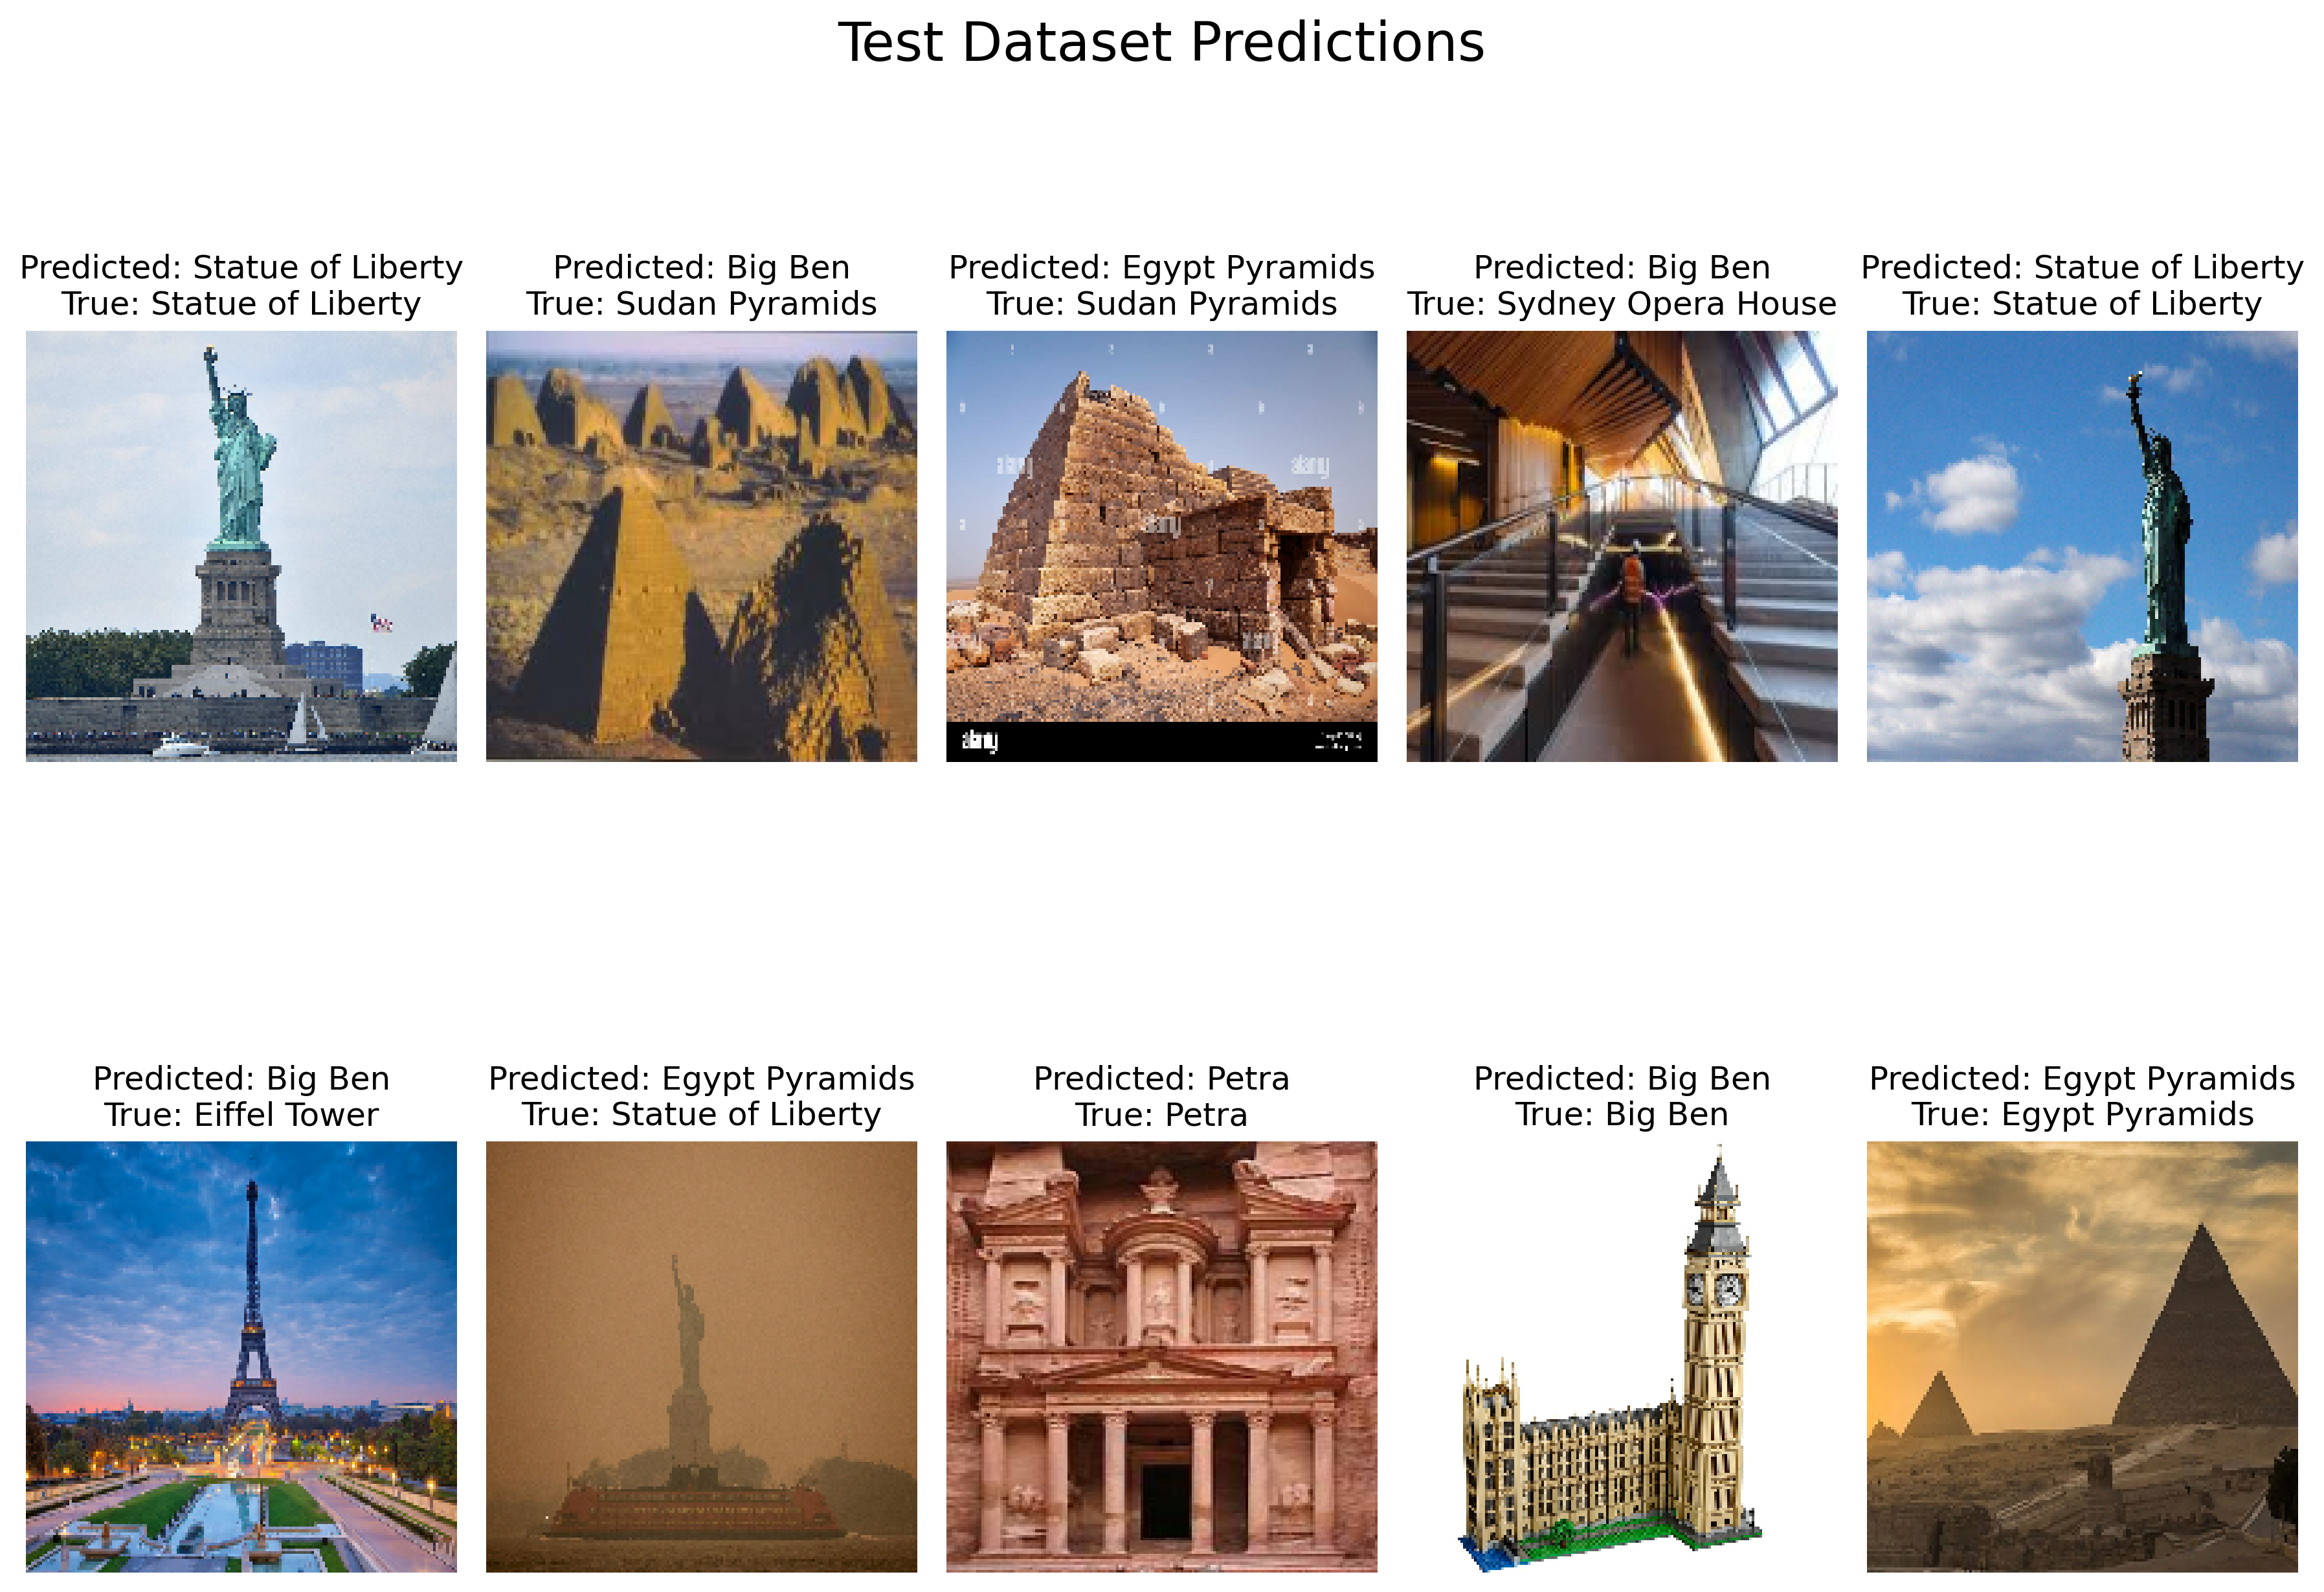

In [48]:
# Getting a batch of images from the test dataset
sample_images, sample_labels = next(iter(test_dataset))
sample_predictions = model.predict(sample_images)

# Mapping the predicted labels to class names
predicted_labels = [class_names[np.argmax(prediction)] for prediction in sample_predictions]

# Creating a figure with a grid of subplots for visualization
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))

# Loop through the subplots
for i in range(2):
    for j in range(5):
        idx = i * 5 + j  
        
        # Preprocess and normalize the image
        image = sample_images[idx] / 255.0
        ax[i, j].set_title(f"Predicted: {predicted_labels[idx]}\nTrue: {class_names[sample_labels[idx]]}")
        ax[i, j].imshow(image)
        ax[i, j].axis("off")

# Increase the resolution of the images
plt.rcParams["figure.dpi"] = 300

# Display the images
plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()
